# Create Network Delay State Feature
#### Daniel Fay

In [1]:
# Import necessary packages
import pandas as pd
import numpy as np
import seaborn
import matplotlib.pyplot as plt
from numpy import array
from math import sqrt
from pyspark.mllib.clustering import KMeans, KMeansModel
%matplotlib inline
sc

In [2]:
# Load dataset
bus_times = pd.read_csv('data/interim/bus_times_weather_spatial.csv', low_memory=False, index_col=0)

In [3]:
bus_times.head()

bus_line  direction        date  month  day day_of_week time_period  hour  \
2      B11        2.0  2016-01-01      1    1      Friday      PeakAM     9   
3      B11        1.0  2016-01-01      1    1      Friday      PeakAM     9   
4      B11        2.0  2016-01-01      1    1      Friday      MidDay    10   
5      B11        1.0  2016-01-01      1    1      Friday      MidDay    10   
6      B11        2.0  2016-01-01      1    1      Friday      MidDay    10   

   minute  trip_time       ...        Conditions  Humidity  PrecipitationIn  \
2      44  38.450000       ...          Overcast      58.0              0.0   
3      52  53.900000       ...          Overcast      58.0              0.0   
4      10  34.700000       ...          Overcast      58.0              0.0   
5      23  41.050000       ...          Overcast      58.0              0.0   
6      33  40.183333       ...          Overcast      58.0              0.0   

  TemperatureF VisibilityMPH  Wind SpeedMPH  totalInjuries  pavementScore  \
2         39.9          10.0           10.4            162         2110.0   
3         39.9          10.0           10.4            162         2110.0   
4         39.9          10.0            6.9            162         2110.0   
5         39.9          10.0            6.9            162         2110.0   
6         39.9          10.0            6.9            162         2110.0   

   potholeCount prev_trip_ratio  
2           237        0.638492  
3           237        1.055520  
4           237        1.017161  
5           237        0.979406  
6           237        0.591185  

[5 rows x 24 columns]

#### Prepare Dataset

In [4]:
# Aggregate datat to hour
bus_times_agg = bus_times.groupby(['bus_line', 'direction', 'date', 'month', 'day', 'hour']).mean().reset_index()
#bus_times_agg['delay'] = bus_times_agg['delay'].round(0)
bus_times_agg.drop(['minute'], axis=1, inplace=True)
bus_times_agg['time'] = pd.to_datetime(bus_times_agg['date']) + pd.to_timedelta(bus_times_agg['hour'],unit='h')

In [5]:
bus_times_agg.head()

bus_line  direction        date  month  day  hour  trip_time  avg_trip_time  \
0      B11        1.0  2016-01-01      1    1     9  53.900000      55.033333   
1      B11        1.0  2016-01-01      1    1    10  47.916667      64.289123   
2      B11        1.0  2016-01-01      1    1    11  48.744444      64.289123   
3      B11        1.0  2016-01-01      1    1    12  72.544444      64.289123   
4      B11        1.0  2016-01-01      1    1    13  56.411111      64.289123   

   std_trip_time  delay_time  Humidity  PrecipitationIn  TemperatureF  \
0       7.915746   -1.133333      58.0              0.0          39.9   
1      16.003063  -16.372457      58.0              0.0          39.9   
2      16.003063  -15.544679      60.0              0.0          39.0   
3      16.003063    8.255321      57.0              0.0          39.0   
4      16.003063   -7.878012      55.0              0.0          39.0   

   VisibilityMPH  totalInjuries  pavementScore  potholeCount  prev_trip_ratio  \
0           10.0          162.0         2110.0         237.0         1.055520   
1           10.0          162.0         2110.0         237.0         0.808964   
2           10.0          162.0         2110.0         237.0         0.777045   
3           10.0          162.0         2110.0         237.0         0.790328   
4           10.0          162.0         2110.0         237.0         0.986783   

                 time  
0 2016-01-01 09:00:00  
1 2016-01-01 10:00:00  
2 2016-01-01 11:00:00  
3 2016-01-01 12:00:00  
4 2016-01-01 13:00:00

In [6]:
 # Create unique id for inbound and outbound
delay_states = bus_times_agg.copy()
bus_line_id = []
for idx, row in delay_states.iterrows():
    bus_line_id.append(row['bus_line'] + '_' + str(row['direction']))
                  
delay_states['bus_line'] = bus_line_id

In [7]:
# pivot data
delay_states = delay_states.pivot(index='time', columns='bus_line', values='delay_time').reset_index()

In [8]:
delay_states.head()

bus_line                time   B11_1.0   B11_2.0    B15_1.0    B15_2.0  \
0        2016-01-01 05:00:00       NaN       NaN   4.551843  -2.485470   
1        2016-01-01 06:00:00       NaN       NaN  -6.139912   1.538184   
2        2016-01-01 07:00:00       NaN       NaN -12.081579  18.738184   
3        2016-01-01 08:00:00       NaN       NaN -13.064912  13.979851   
4        2016-01-01 09:00:00 -1.133333  0.648718 -11.342690  -4.000705   

bus_line    B37_2.0   B38_1.0   B38_2.0     B3_1.0     B3_2.0    ...      \
0        -24.273699 -6.608115 -1.365566 -17.719487 -10.583346    ...       
1               NaN  8.655595       NaN  -3.255128  -0.637500    ...       
2               NaN -8.698571 -0.899603  -3.680128  -1.704167    ...       
3               NaN -2.898571  1.317063   9.403205  -2.937500    ...       
4               NaN -1.465238  0.617063  -0.446795  -1.887500    ...       

bus_line     B4_1.0     B4_2.0   B54_1.0    B54_2.0  B57_1.0  B57_2.0  \
0        -17.356149  -4.737758 -5.827508 -10.138674      NaN      NaN   
1               NaN -10.589583 -4.679167   5.097585      NaN      NaN   
2               NaN        NaN  2.904167  -2.841304      NaN      NaN   
3               NaN        NaN -3.812500  -3.391304      NaN      NaN   
4        -19.322222  26.877083 -3.995833  -3.941304      NaN      NaN   

bus_line    B62_1.0    B62_2.0     B8_1.0     B8_2.0  
0        -15.519092 -16.256546 -12.411175  -1.832746  
1               NaN  19.219737  -7.154023   4.572222  
2               NaN -22.171930 -14.737356 -15.152778  
3         -1.660417        NaN  -8.920690  -8.519444  
4          6.406250  32.994737 -19.604023  22.463889  

[5 rows x 24 columns]

In [9]:
# Time lag of 1 hour
delay_states['time'] = delay_states['time'] + pd.Timedelta(hours=-1)
delay_states.fillna(0, inplace=True)

In [10]:
delay_states.head()

bus_line                time   B11_1.0   B11_2.0    B15_1.0    B15_2.0  \
0        2016-01-01 04:00:00  0.000000  0.000000   4.551843  -2.485470   
1        2016-01-01 05:00:00  0.000000  0.000000  -6.139912   1.538184   
2        2016-01-01 06:00:00  0.000000  0.000000 -12.081579  18.738184   
3        2016-01-01 07:00:00  0.000000  0.000000 -13.064912  13.979851   
4        2016-01-01 08:00:00 -1.133333  0.648718 -11.342690  -4.000705   

bus_line    B37_2.0   B38_1.0   B38_2.0     B3_1.0     B3_2.0    ...      \
0        -24.273699 -6.608115 -1.365566 -17.719487 -10.583346    ...       
1          0.000000  8.655595  0.000000  -3.255128  -0.637500    ...       
2          0.000000 -8.698571 -0.899603  -3.680128  -1.704167    ...       
3          0.000000 -2.898571  1.317063   9.403205  -2.937500    ...       
4          0.000000 -1.465238  0.617063  -0.446795  -1.887500    ...       

bus_line     B4_1.0     B4_2.0   B54_1.0    B54_2.0  B57_1.0  B57_2.0  \
0        -17.356149  -4.737758 -5.827508 -10.138674      0.0      0.0   
1          0.000000 -10.589583 -4.679167   5.097585      0.0      0.0   
2          0.000000   0.000000  2.904167  -2.841304      0.0      0.0   
3          0.000000   0.000000 -3.812500  -3.391304      0.0      0.0   
4        -19.322222  26.877083 -3.995833  -3.941304      0.0      0.0   

bus_line    B62_1.0    B62_2.0     B8_1.0     B8_2.0  
0        -15.519092 -16.256546 -12.411175  -1.832746  
1          0.000000  19.219737  -7.154023   4.572222  
2          0.000000 -22.171930 -14.737356 -15.152778  
3         -1.660417   0.000000  -8.920690  -8.519444  
4          6.406250  32.994737 -19.604023  22.463889  

[5 rows x 24 columns]

In [11]:
# Output data to csv
delay_states.iloc[:,1:].to_csv('data/interim/delay_states.csv', header=False, index=False)

#### Cluster Delay States

In [12]:
data = sc.textFile('data/interim/delay_states.csv')
parsedData = data.map(lambda line: array([float(x) for x in line.split(',')]))

In [13]:
sse = []
for k in range(2,13):
# Build the model (cluster the data)
    clusters = KMeans.train(parsedData, k, maxIterations=10, initializationMode="random", seed=234)

    # Evaluate clustering by computing Within Set Sum of Squared Errors
    def error(point):
        center = clusters.centers[clusters.predict(point)]
        return sqrt(sum([x**2 for x in (point - center)]))

    WSSSE = parsedData.map(lambda point: error(point)).reduce(lambda x, y: x + y)
    sse.append(WSSSE)
    print("Within Set Sum of Squared Error for k: "+str(k)+ " = " + str(WSSSE))

Within Set Sum of Squared Error for k: 2 = 389046.43359
Within Set Sum of Squared Error for k: 3 = 367036.5181
Within Set Sum of Squared Error for k: 4 = 353078.948595
Within Set Sum of Squared Error for k: 5 = 345112.31643
Within Set Sum of Squared Error for k: 6 = 339600.613566
Within Set Sum of Squared Error for k: 7 = 336099.140328
Within Set Sum of Squared Error for k: 8 = 335023.367343
Within Set Sum of Squared Error for k: 9 = 328316.277223
Within Set Sum of Squared Error for k: 10 = 327189.621341
Within Set Sum of Squared Error for k: 11 = 323309.041043
Within Set Sum of Squared Error for k: 12 = 320552.418586


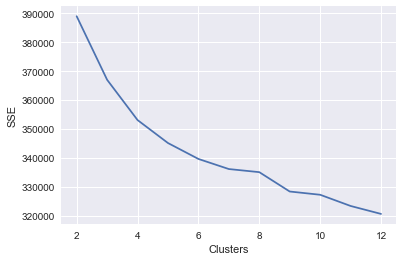

In [14]:
plt.plot(range(2,13), sse)
plt.xlabel('Clusters')
plt.ylabel('SSE')

In [15]:
# Train model with optimized k
clusters = KMeans.train(parsedData, 6, maxIterations=10, initializationMode="random", seed=3)

In [16]:
delay_states['ntwk_delay_lag1hr'] = clusters.predict(parsedData).collect()

In [17]:
delay_states.ntwk_delay_lag1hr.unique()

array([4, 5, 2, 0, 3, 1])

In [18]:
delay_states['month'] = delay_states['time'].dt.month
delay_states['day'] = delay_states['time'].dt.day
delay_states['hour'] = delay_states['time'].dt.hour
delay_states.head()

bus_line                time   B11_1.0   B11_2.0    B15_1.0    B15_2.0  \
0        2016-01-01 04:00:00  0.000000  0.000000   4.551843  -2.485470   
1        2016-01-01 05:00:00  0.000000  0.000000  -6.139912   1.538184   
2        2016-01-01 06:00:00  0.000000  0.000000 -12.081579  18.738184   
3        2016-01-01 07:00:00  0.000000  0.000000 -13.064912  13.979851   
4        2016-01-01 08:00:00 -1.133333  0.648718 -11.342690  -4.000705   

bus_line    B37_2.0   B38_1.0   B38_2.0     B3_1.0     B3_2.0  ...   B57_1.0  \
0        -24.273699 -6.608115 -1.365566 -17.719487 -10.583346  ...       0.0   
1          0.000000  8.655595  0.000000  -3.255128  -0.637500  ...       0.0   
2          0.000000 -8.698571 -0.899603  -3.680128  -1.704167  ...       0.0   
3          0.000000 -2.898571  1.317063   9.403205  -2.937500  ...       0.0   
4          0.000000 -1.465238  0.617063  -0.446795  -1.887500  ...       0.0   

bus_line  B57_2.0    B62_1.0    B62_2.0     B8_1.0     B8_2.0  \
0             0.0 -15.519092 -16.256546 -12.411175  -1.832746   
1             0.0   0.000000  19.219737  -7.154023   4.572222   
2             0.0   0.000000 -22.171930 -14.737356 -15.152778   
3             0.0  -1.660417   0.000000  -8.920690  -8.519444   
4             0.0   6.406250  32.994737 -19.604023  22.463889   

bus_line  ntwk_delay_lag1hr  month  day  hour  
0                         4      1    1     4  
1                         5      1    1     5  
2                         5      1    1     6  
3                         5      1    1     7  
4                         5      1    1     8  

[5 rows x 28 columns]

In [19]:
delay_states_labels = delay_states[['ntwk_delay_lag1hr', 'month', 'day', 'hour']]

### Merge Network Delay State (timelag=1hr)

In [20]:
bus_times_nds = pd.merge(bus_times, delay_states_labels, on=['month','day','hour'], how='left')
bus_times_nds.head()

bus_line  direction        date  month  day day_of_week time_period  hour  \
0      B11        2.0  2016-01-01      1    1      Friday      PeakAM     9   
1      B11        1.0  2016-01-01      1    1      Friday      PeakAM     9   
2      B11        2.0  2016-01-01      1    1      Friday      MidDay    10   
3      B11        1.0  2016-01-01      1    1      Friday      MidDay    10   
4      B11        2.0  2016-01-01      1    1      Friday      MidDay    10   

   minute  trip_time        ...         Humidity  PrecipitationIn  \
0      44  38.450000        ...             58.0              0.0   
1      52  53.900000        ...             58.0              0.0   
2      10  34.700000        ...             58.0              0.0   
3      23  41.050000        ...             58.0              0.0   
4      33  40.183333        ...             58.0              0.0   

   TemperatureF VisibilityMPH Wind SpeedMPH  totalInjuries  pavementScore  \
0          39.9          10.0          10.4            162         2110.0   
1          39.9          10.0          10.4            162         2110.0   
2          39.9          10.0           6.9            162         2110.0   
3          39.9          10.0           6.9            162         2110.0   
4          39.9          10.0           6.9            162         2110.0   

   potholeCount  prev_trip_ratio ntwk_delay_lag1hr  
0           237         0.638492               2.0  
1           237         1.055520               2.0  
2           237         1.017161               4.0  
3           237         0.979406               4.0  
4           237         0.591185               4.0  

[5 rows x 25 columns]

In [21]:
bus_times_nds.dropna(inplace=True)

In [22]:
bus_times_nds.to_csv('data/processed/bus_network_data.csv')